# Case 3: Patient Drug Review
Cognitive Systems for Health Technology Applications, Spring 2019 
Mika Paavola
Metropolia University of Applied science

# Aim of the study
The aim of this assignment is to learn to use neural networks to process text data and predict ratings associated to the text. 

# importing Libraries and data

In [26]:
# Import basic libraries
import numpy as np 
import pandas as pd 
import keras
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding, GRU
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight


#Print list of data from directory
print(os.listdir("Case3/data"))

['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data

The structure of the data is that a patient with a unique ID purchases a drug that meets his condition and writes a review and rating for the drug he/she purchased on the date. 

In [27]:
# Create dataframe from csv train and test data
train = pd.read_csv('Case3/data/drugsComTrain_raw.csv')
test = pd.read_csv('Case3/data/drugsComTest_raw.csv')

#show first rows from train set
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


# Hyperparameters

In [28]:
num_of_data = 50000
num_of_epochs = 40
batch_size = 100
max_length = 50
num_of_words = 1000
dimension_of_embedding = 8

In [29]:
#show first rows from test set
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [30]:
#Prepare training data

samples = train['review'].iloc[:num_of_data]
tokenizer = Tokenizer(num_words = num_of_words)
tokenizer.fit_on_texts(samples)

data = tokenizer.texts_to_sequences(samples)

data = pad_sequences(data, maxlen = max_length)


In [31]:
r = train['rating'].iloc[:num_of_data]
labels = -1*(r <= 4) + 1*(r >= 7)
print(labels.head(20))

one_hot_labels = to_categorical(labels, num_classes = 3)


#Class Wights
class_weight = compute_class_weight('balanced', [-1,0,1], labels)

weights = {0:class_weight[0], 1:class_weight[1], 2:class_weight[2]}
print(weights)

0     1
1     1
2     0
3     1
4     1
5    -1
6    -1
7     1
8    -1
9     1
10    1
11    1
12   -1
13   -1
14   -1
15    1
16    1
17    1
18    1
19    1
Name: rating, dtype: int32
{0: 1.3245383983681687, 1: 3.821753420469311, 2: 0.5041949015811552}


# Explorer data
checking some basic information about data*

In [32]:
#check that colum names are same at train set and test set
list(train) == list(test)

True

In [33]:
# How many rows are there in train and test sets?
rows_train = train.values.shape[0]
rows_test = test.values.shape[0]
print('Rows in train set:', rows_train)
print('Rows in test set:', rows_test)

# What is the ratio of the train and test set sizes?
ratio = rows_train/rows_test
print('Ratio (train:test) = {:.3f}'.format(ratio))

Rows in train set: 161297
Rows in test set: 53766
Ratio (train:test) = 3.000


In [34]:
# How many unique medical conditions there are?
train['condition'].unique().size, test['condition'].unique().size

(885, 709)

In [35]:
# How many drug names there are?
train['drugName'].unique().size, test['drugName'].unique().size

(3436, 2637)

In [36]:
# What are the most common medical conditions?
conditions = train['condition'].value_counts().sort_values(ascending=False)
conditions[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

# Plot data

In [37]:
from matplotlib import pyplot, pylab

plt = pyplot
%matplotlib inline

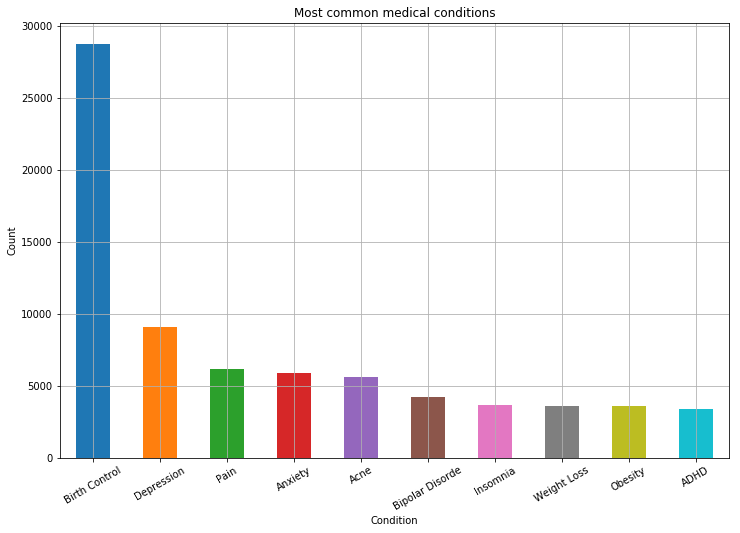

In [38]:
# Change the default figure size
plt.rcParams['figure.figsize'] = [12, 8]

# Plot the most common medical conditions
conditions[:10].plot(kind='bar', rot = 30)
plt.title('Most common medical conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.grid()
plt.show()

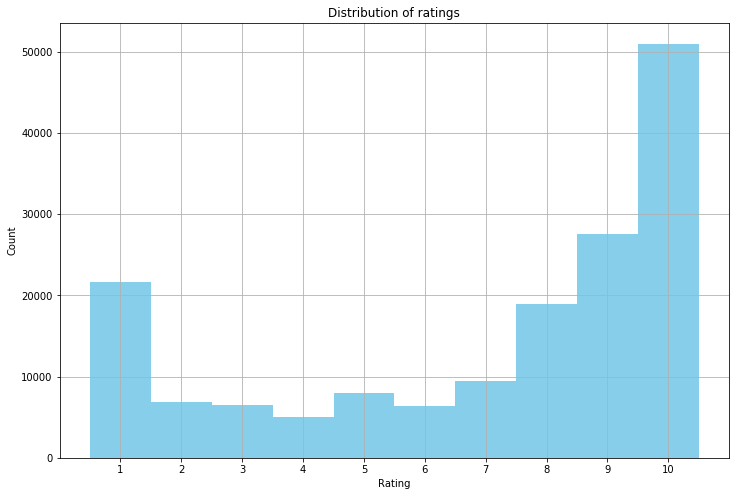

In [39]:
# How are the ratings distributed?
train['rating'].hist(color='skyblue', bins = range(1, 12), align = 'left')
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 11))
plt.show()

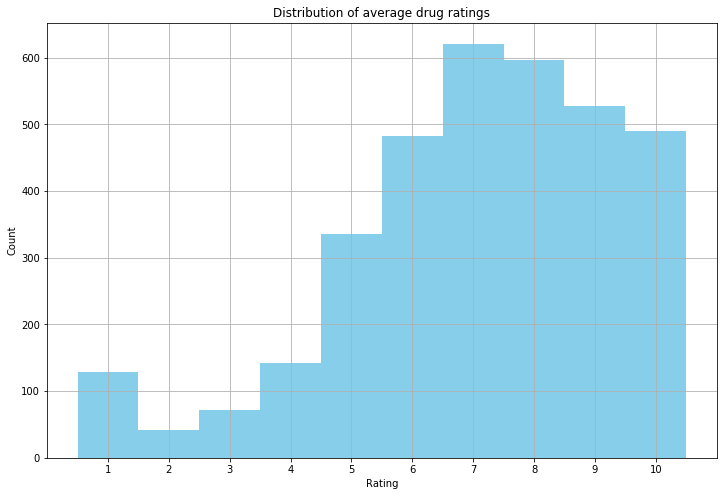

In [40]:
# What is the average rating grouped by the drug name?
rating_avgs = (train['rating'].groupby(train['drugName']).mean())
rating_avgs.hist(color='skyblue', bins = range(1, 12), align = 'left')
plt.title('Distribution of average drug ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 11))
plt.show()

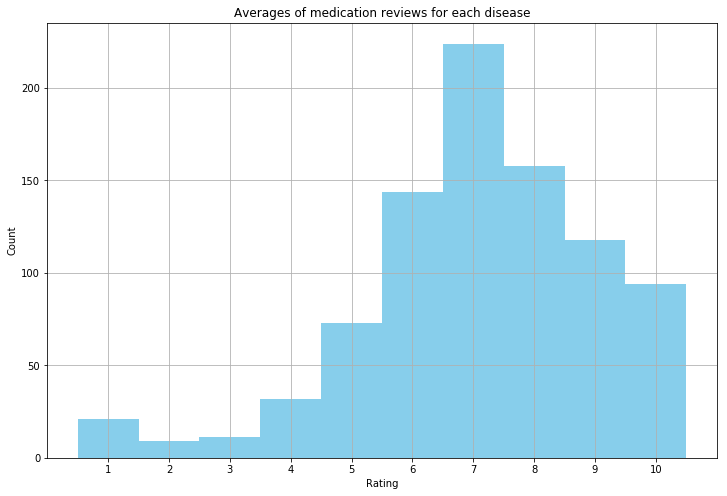

In [41]:
# What is the average rating grouped by the condition?
rating_avgs = (train['rating'].groupby(train['condition']).mean())
rating_avgs.hist(color='skyblue', bins = range(1, 12), align = 'left')
plt.title('Averages of medication reviews for each disease')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 11))
plt.show()

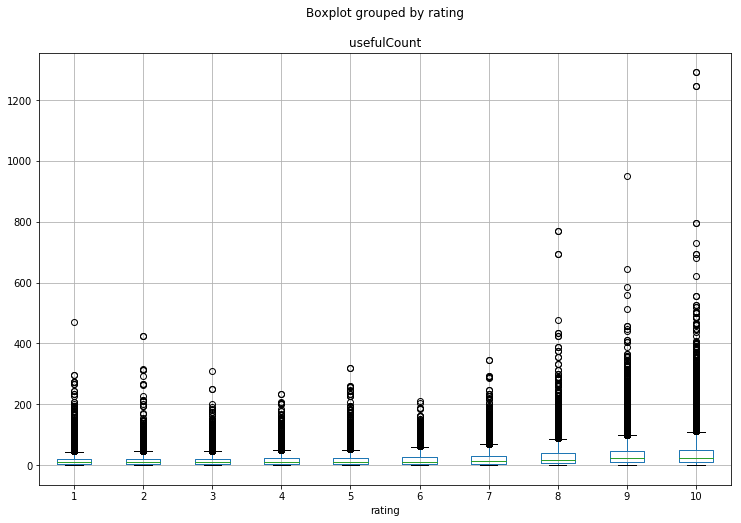

In [42]:
# How the usefullness is distributed by rating?
boxplot = train.boxplot(column = 'usefulCount',by = 'rating')

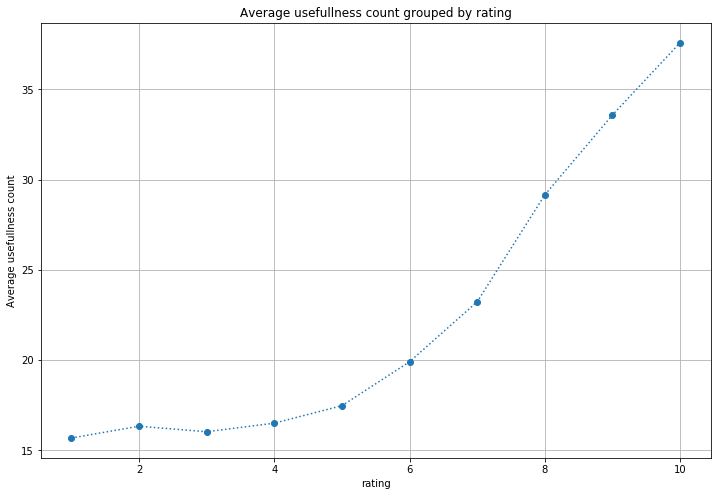

In [43]:
# What is the average usefullness count by rating?
train.groupby('rating')['usefulCount'].mean().plot(style = 'o:')
plt.ylabel('Average usefullness count')
plt.title('Average usefullness count grouped by rating')
plt.grid()
plt.show()

In [44]:
# What were the most useful reviews?
useful_train = train.sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:10]

,uniqueID,drugName,condition,review,rating,date,usefulCount
6716,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
33552,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
21708,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
146145,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949
58608,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
16889,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
2039,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
152838,89825,Celexa,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
5218,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10,19-Jul-10,730


# Classification with scikit-learn

In [47]:
# Import libraries
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['review'].iloc[:10000])

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(test['review'].iloc[:5000])

# Create a column with binary rating indicating the polarity of a review
train['binary_rating'] = train['rating'] > 5
y_train_rating = train['binary_rating'].iloc[:10000]

test['binary_rating'] = test.rating > 5
y_test_rating = test['binary_rating'].iloc[:5000]

# Use Naive Bayes classifier
clf = MultinomialNB().fit(X_train, y_train_rating)

# Evaluate the model
pred = clf.predict(X_test)

print("Accuracy: {:.3f}".format(clf.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Accuracy: 0.702
Confusion Matrix
[[  18    1]
 [1489 3492]]


In [49]:
# Use random forest classifier
start = time.time()
rfc_rating = RandomForestClassifier(n_estimators = 100, 
                                    random_state = 42, 
                                    max_depth = 10000, 
                                    min_samples_split = 0.001)
rfc_rating.fit(X_train, y_train_rating)
end = time.time()
print("Training time: {:.0f} seconds.".format(end-start))

# Evaluate the model
pred = rfc_rating.predict(X_test)

print("Accuracy: {:.3f}".format(rfc_rating.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Training time: 7 seconds.
Accuracy: 0.747
Confusion Matrix
[[ 275   31]
 [1232 3462]]


# Classification
Using keras for classification funciton

In [50]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(data, one_hot_labels,
                                    test_size = 0.3, random_state = 2019)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid,
                                    test_size = 0.5, random_state = 2019)

In [51]:
# Create a simple sequential model
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

model.add(Embedding(num_of_words, 50,
                    input_length = max_length))

model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(8))
model.add(Dense(12))
model.add(Dropout(0.2))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 32)            10624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)        

In [53]:
history = model.fit(x_train, y_train, 
                    epochs = num_of_epochs, 
                    batch_size = batch_size,
                    verbose = 2,
                    validation_data = (x_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 35000 samples, validate on 7500 samples
Epoch 1/40
 - 24s - loss: 0.7315 - acc: 0.7186 - val_loss: 0.6582 - val_acc: 0.7463
Epoch 2/40
 - 22s - loss: 0.6367 - acc: 0.7591 - val_loss: 0.6414 - val_acc: 0.7475
Epoch 3/40
 - 22s - loss: 0.6108 - acc: 0.7701 - val_loss: 0.6346 - val_acc: 0.7495
Epoch 4/40
 - 22s - loss: 0.5910 - acc: 0.7765 - val_loss: 0.6416 - val_acc: 0.7504
Epoch 5/40
 - 23s - loss: 0.5726 - acc: 0.7847 - val_loss: 0.6300 - val_acc: 0.7533
Epoch 6/40
 - 22s - loss: 0.5583 - acc: 0.7889 - val_loss: 0.6315 - val_acc: 0.7540
Epoch 7/40
 - 22s - loss: 0.5452 - acc: 0.7942 - val_loss: 0.6381 - val_acc: 0.7507
Epoch 8/40
 - 23s - loss: 0.5357 - acc: 0.7985 - val_loss: 0.6399 - val_acc: 0.7585
Epoch 9/40
 - 22s - loss: 0.5233 - acc: 0.8031 - val_loss: 0.6307 - val_acc: 0.7579
Epoch 10/40
 - 23s - loss: 0.5132 - acc: 0.8072 - val_loss: 0.6336 - val_acc: 0.7560
Epoch 11/40
 - 22s - loss: 0.5028 - acc: 0.8118 - val_loss: 0.

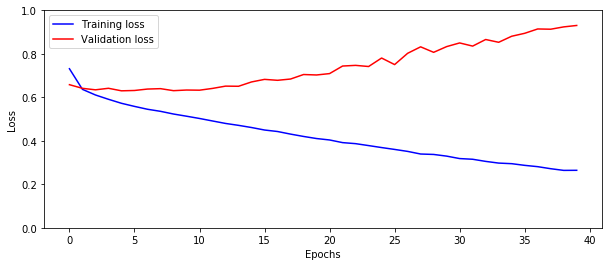

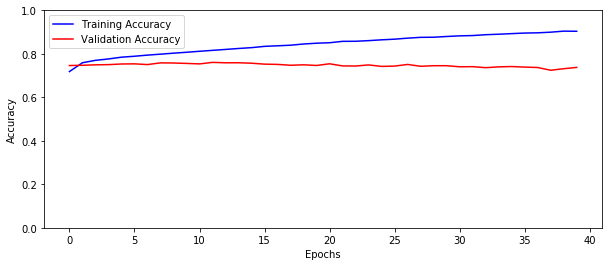

In [54]:
# Plot the accuracy and loss
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
train_acc = history.history['acc']

plt.figure(figsize=(10,4))
plt.ylim(0,1)
plt.plot(train_loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.ylim(0,1)
plt.plot(train_acc, 'b', label='Training Accuracy')
plt.plot(val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Conclusion


It was quite hard mission to get high validation accuracy and at the end whole code seems like mess after all tries to get code wroking properly

I heard that there could be a pre trained model which could be give more accurate result but i dont have time to find that. 
